In [52]:
import pandas as pd
from category_encoders import CountEncoder
import numpy as np
import sklearn.model_selection
from catboost import CatBoostClassifier


import seaborn as sns
import matplotlib.pyplot as plt

# Первый взгляд на данные


In [53]:
crm_data = pd.read_csv("crm_data.csv")
crm_goose = pd.read_csv("crm_goose.csv")
s_subs = pd.read_csv("sample_submit.csv")
trans = pd.read_csv("transactions.csv")

In [54]:
crm_data.head()

,clnt_id,clnt_gender,clnt_age,clnt_device,clnt_device_get,has_car,has_estate,clnt_children,clnt_income,clnt_pick,clnt_fortune,clnt_status,clnt_system,spend_last,spend_level,spend_points,manager_contact,is_premium
0,2001,1.0,32,sO@*%lun08,vgIXi0LgoZHQ71Mmekm1,0.0,0.0,1,180000,2,6,3,1,1428,320,76,7227.0,1.0
1,2006,1.0,20,)!%OA9qpZP,lmE6l7DelsqZNYgxcsAZ,1.0,0.0,0,250000,5,11,4,1,1428,1000,66,7227.0,1.0
2,2012,0.0,24,IgSHlRCsd#,yhUtC1GSVpWWNPCI9EYo,NaN,0.0,0,310000,4,8,4,1,1428,1750,18,7233.0,1.0
3,2013,0.0,42,SSbZb5Hpun,TM4ptl78Lwzhng7PAY4G,1.0,0.0,1,110000,8,9,6,1,1428,1180,30,7227.0,1.0
4,2014,0.0,25,N)Eb*EJXD4,lmE6l7DelsqZNYgxcsAZ,1.0,0.0,1,300000,8,10,4,1,1428,1000,24,7227.0,1.0


In [55]:
crm_data.describe()

,clnt_id,clnt_gender,clnt_age,has_car,has_estate,clnt_children,clnt_income,clnt_pick,clnt_fortune,clnt_status,clnt_system,spend_last,spend_level,spend_points,manager_contact,is_premium
count,2899.000000,2786.000000,2899.000000,2692.000000,2711.000000,2899.000000,2.899000e+03,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.00000,755.000000,1538.000000
mean,3501.526388,0.502513,104.801311,0.503715,0.148654,0.332873,8.736288e+05,4.456019,19.514660,9.270093,1.223870,1427.168679,839.284926,24.61573,7215.978808,0.469441
std,865.813819,0.500083,376.473500,0.500079,0.355812,0.579074,4.225547e+06,2.879040,5.048834,6.429195,0.469096,6.500000,2716.802823,65.01844,33.099153,0.499228
min,2000.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,5.000000,0.000000,1.000000,1295.000000,0.000000,0.00000,7122.000000,0.000000
25%,2748.500000,0.000000,23.000000,0.000000,0.000000,0.000000,1.000000e+05,2.000000,16.000000,4.000000,1.000000,1428.000000,200.000000,0.00000,7227.000000,0.000000
50%,3502.000000,1.000000,26.000000,1.000000,0.000000,0.000000,2.000000e+05,4.000000,20.000000,9.000000,1.000000,1428.000000,427.000000,0.00000,7227.000000,0.000000
75%,4249.500000,1.000000,31.000000,1.000000,0.000000,1.000000,3.000000e+05,7.000000,23.000000,15.000000,1.000000,1428.000000,980.000000,0.00000,7227.000000,1.000000
max,4999.000000,1.000000,2001.000000,1.000000,1.000000,4.000000,3.900000e+07,9.000000,34.000000,31.000000,3.000000,1428.000000,120000.000000,594.00000,7248.000000,1.000000


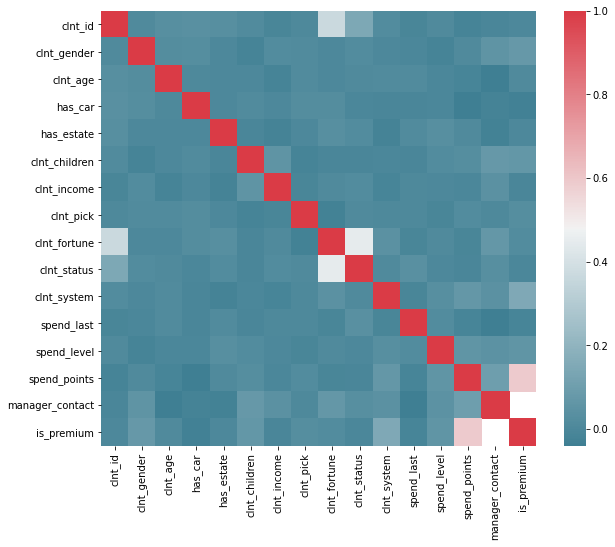

In [57]:
#Нарисуем матрицу корреляций
f, ax = plt.subplots(figsize=(10, 8))
corr = crm_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [6]:
crm_data['is_premium'].value_counts()

0.0    816
1.0    722
Name: is_premium, dtype: int64

In [7]:
trans.head()

,clnt_id,date,mcc_id,sum
0,2013,1211,44,1000.0
1,2019,1211,5,-176.0
2,2019,1211,5,-105.0
3,2019,1211,33,-2000.0
4,2019,1211,33,-230.0


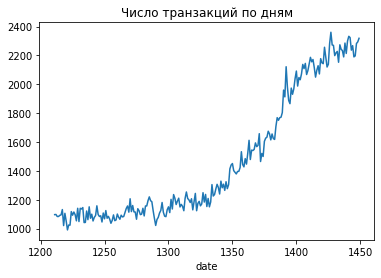

In [8]:
trans.groupby('date').count()['clnt_id'].plot(title = 'Число транзакций по дням')

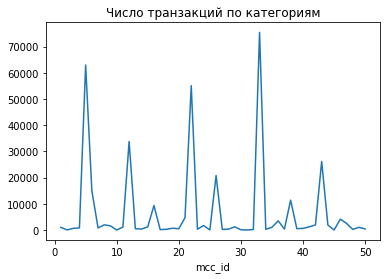

In [9]:
trans.groupby('mcc_id').count()['clnt_id'].plot(title = 'Число транзакций по категориям')

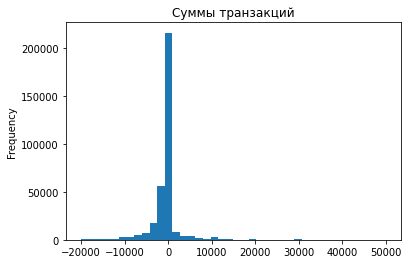

In [26]:
#Рисовать просто гистограмму сумм бессмысленно, обрубим хвосты
trans['sum'][(trans['sum'] < 50000) & (trans['sum'] > -20000)].plot(kind = 'hist', bins = 40, title = 'Суммы транзакций')

In [27]:
#Посмотрим какую долю выборки мы описали:
len(trans['sum'][(trans['sum'] < 50000) & (trans['sum'] > -20000)])/len(trans)

0.9698559145246949

In [28]:
crm_goose.head()

,clnt_id,grey_goose_F0,grey_goose_F1,grey_goose_F2,grey_goose_F3,grey_goose_F4,goose_agg_0,goose_agg_1,goose_agg_2,goose_agg_3,goose_agg_4,goose_agg_5,goose_agg_6,goose_agg_7,goose_agg_8,goose_agg_9,goose_agg_10,goose_agg_11,goose_agg_12,goose_agg_13,goose_agg_14,goose_agg_15,goose_agg_16,goose_agg_17,goose_agg_18,goose_agg_19,goose_agg_20,goose_agg_21,goose_agg_22,goose_agg_23,goose_agg_24,goose_agg_25,goose_agg_26,goose_agg_27,goose_agg_28,goose_agg_29,wild_goose_A_0,wild_goose_A_1,wild_goose_A_2,wild_goose_A_3,wild_goose_A_4,wild_goose_A_5,wild_goose_A_6,wild_goose_A_7,wild_goose_A_8,wild_goose_A_9
0,3700,0,1,1,1,0,98.0,-87449.0,2138.696906,113.0,2109.798917,-6341.0,-9000.0,-89970.0,-1373.350000,2537.602853,20.0,-105.102041,-60.390476,109.0,7.0,-1053.602410,75.0,109.0,113.0,69.0,-27467.0,20.0,7.0,-13000.0,-1373.350000,-13000.0,105.0,7.0,78.0,98.0,5743.754372,2362.996967,-6000.0,NaN,NaN,NaN,NaN,NaN,12831.625239,5.0
1,4545,0,0,1,1,0,94.0,-542660.0,25775.051604,107.0,25539.710753,316814.0,-22000.0,-622180.0,-6719.833333,8555.979280,9.0,3353.031915,3106.019608,106.0,21.0,-6699.506173,73.0,106.0,107.0,68.0,-40539.0,8.0,21.0,-232310.0,-6171.000000,-232310.0,102.0,19.0,77.0,94.0,NaN,14289.920941,-22000.0,NaN,100000.0,NaN,NaN,NaN,NaN,6.0
2,3656,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1530.359435,-3800.0,-10500.0,20000.0,NaN,NaN,NaN,9347.738140,6.0
3,4445,1,1,1,1,0,46.0,-122665.0,9808.466833,54.0,9415.716205,-99778.0,-46000.0,-140338.0,-5248.250000,12232.141860,13.0,-2060.391304,-2078.708333,53.0,8.0,-3228.026316,40.0,53.0,54.0,38.0,-62979.0,12.0,8.0,-46000.0,-5613.769231,-46000.0,48.0,7.0,44.0,46.0,871.779789,3386.310076,-10000.0,NaN,NaN,NaN,NaN,NaN,935.269034,6.0
4,4112,0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3755.440498,-8000.0,-1111.0,720.0,1.0,-39.0,NaN,934.470566,16.0


In [29]:
crm_goose.describe()

,clnt_id,grey_goose_F0,grey_goose_F1,grey_goose_F2,grey_goose_F3,grey_goose_F4,goose_agg_0,goose_agg_1,goose_agg_2,goose_agg_3,goose_agg_4,goose_agg_5,goose_agg_6,goose_agg_7,goose_agg_8,goose_agg_9,goose_agg_10,goose_agg_11,goose_agg_12,goose_agg_13,goose_agg_14,goose_agg_15,goose_agg_16,goose_agg_17,goose_agg_18,goose_agg_19,goose_agg_20,goose_agg_21,goose_agg_22,goose_agg_23,goose_agg_24,goose_agg_25,goose_agg_26,goose_agg_27,goose_agg_28,goose_agg_29,wild_goose_A_0,wild_goose_A_1,wild_goose_A_2,wild_goose_A_3,wild_goose_A_4,wild_goose_A_5,wild_goose_A_6,wild_goose_A_7,wild_goose_A_8,wild_goose_A_9
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2541.000000,2.540000e+03,2.541000e+03,2554.000000,2543.000000,2.547000e+03,2.493000e+03,2.551000e+03,2493.000000,2.466000e+03,2510.000000,2541.000000,2547.000000,2551.000000,2551.000000,2540.000000,2547.000000,2551.000000,2554.000000,2541.000000,2.506000e+03,2506.000000,2554.000000,2.551000e+03,2510.000000,2.554000e+03,2547.000000,2541.000000,2551.000000,2541.000000,1072.000000,2469.000000,2696.000000,1740.000000,1.447000e+03,375.000000,375.000000,75.000000,2169.000000,2895.000000
mean,3502.249142,0.485587,0.502745,0.512354,0.496911,0.489019,111.670602,-2.748151e+05,8.667848e+03,129.603367,8635.826752,-1.435627e+05,-3.634734e+04,-3.105795e+05,-5160.892267,9.006695e+03,23.950996,-1416.343492,-1397.543693,126.853783,10.943944,-2951.057508,69.358461,126.853783,129.603367,63.993310,-1.150336e+05,22.932562,11.030149,-6.932468e+04,-5064.132061,-6.990062e+04,121.236356,10.455333,72.511956,111.670602,10985.710781,6864.438302,-19633.830861,-5135.647111,4.674982e+04,1.709333,-1392.214633,1.613333,12708.343533,7.713644
std,866.121404,0.499878,0.500078,0.499933,0.500076,0.499965,93.533154,6.094800e+05,2.506642e+04,108.466296,24184.523915,4.072259e+05,2.445554e+05,6.477633e+05,8806.873244,2.944265e+04,20.209061,3356.704213,3170.883254,106.102345,6.014198,3853.191617,38.181450,106.102345,108.466296,35.315501,3.878538e+05,19.393556,6.047361,2.768133e+05,7839.538731,2.766935e+05,101.302879,5.791529,39.975283,93.533154,23494.111416,10928.414821,30736.929237,10447.419907,1.988338e+05,1.458258,3139.207471,1.229077,26792.545728,4.248404
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.015670e+07,4.242641e+00,1.000000,4.242641,-1.212564e+07,-1.200000e+07,-2.021463e+07,-200000.000000,0.000000e+00,1.000000,-89065.477941,-80302.258278,1.000000,1.000000,-100126.278689,1.000000,1.000000,1.000000,1.000000,-1.217560e+07,1.000000,1.000000,-1.200000e+07,-154176.645570,-1.200000e+07,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-400000.000000,-255107.333333,1.000000e+00,1.000000,-44400.000000,1.000000,0.000000,1.000000
25%,2749.250000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,-3.050812e+05,3.190055e+03,50.000000,3234.497339,-1.958645e+05,-4.000000e+04,-3.406440e+05,-5511.312500,2.437938e+03,10.000000,-1918.494949,-1952.370115,49.000000,6.000000,-3238.118269,38.000000,49.000000,50.000000,35.000000,-1.193498e+05,10.000000,6.000000,-8.000000e+04,-5613.035511,-8.000000e+04,47.000000,6.000000,39.500000,43.000000,1474.403566,1596.393376,-23000.000000,-5607.875000,3.117500e+03,1.000000,-1312.000000,1.000000,2013.561397,4.000000
50%,3504.500000,0.000000,1.000000,1.000000,0.000000,0.000000,88.000000,-1.599860e+05,5.529753e+03,101.500000,5599.425325,-9.224400e+04,-1.680000e+04,-1.823370e+05,-3039.687500,4.974028e+03,19.000000,-991.600000,-1017.187500,99.000000,10.000000,-2004.263331,67.000000,99.000000,101.500000,62.000000,-6.036400e+04,18.000000,10.500000,-4.000000e+04,-3038.655080,-4.000000e+04,95.000000,10.000000,70.000000,88.000000,4020.476209,3516.494032,-10000.000000,-2285.354167,1.050000e+04,1.000000,-540.000000,1.000000,4905.050847,7.000000
75%,4251.750000,1.000000,1.000000,1.000000,1.000000,1.000000,152.000000,-7.509675e+04,9.450927e+03,178.000000,9495.098828,-2.557300e+04,-8.000000e+03,-8.546600e+04,-1693.815789,9.954990e+03,32.000000,-422

# Сформируем Train и Test

In [30]:
#Для того, чтобы собрать тестовую выборку:
s_subs['is_test'] = 1
s_subs.drop('is_premium', axis = 1, inplace = True)

data_new = crm_data.merge(s_subs, on = 'clnt_id', how = 'left')
train_data = data_new[data_new['is_test'].apply(lambda x: False if x >= 0 else True)].drop(columns = 'is_test')
test_data = data_new[data_new['is_test'].apply(lambda x: True if x >= 0 else False)].drop(columns = 'is_test')

test_data_buf = test_data

In [31]:
test_data[test_data['clnt_id'] == 2301]

,clnt_id,clnt_gender,clnt_age,clnt_device,clnt_device_get,has_car,has_estate,clnt_children,clnt_income,clnt_pick,clnt_fortune,clnt_status,clnt_system,spend_last,spend_level,spend_points,manager_contact,is_premium
1674,2301,0.0,1922,KnasAzg4Vf,yhUtC1GSVpWWNPCI9EYo,1.0,0.0,1,230000,6,9,6,1,1428,100,0,NaN,NaN


In [32]:
#Джойнимся с доп. данными:
train_data = train_data.merge(crm_goose, on = 'clnt_id')
test_data = test_data.merge(crm_goose, on = 'clnt_id')

In [33]:
#Проверяем размерность теста
len(test_data), len(s_subs)

(1361, 1361)

# Работа с фичами

In [34]:
#Заменяем кат. фичи
c_e = CountEncoder(cols=['clnt_device', 'clnt_device_get'])
train_data = c_e.fit_transform(train_data)
test_data = c_e.transform(test_data)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [44]:
#В первоначальном анализе была замечена странность в поле 'clnt_age'
train_data[['clnt_age']].value_counts().index.values

array([(24,), (23,), (25,), (22,), (26,), (27,), (28,), (21,), (29,),
       (30,), (32,), (31,), (33,), (20,), (35,), (34,), (36,), (38,),
       (1900,), (37,), (42,), (39,), (41,), (40,), (45,), (44,), (47,),
       (53,), (1942,), (1991,), (1954,), (1989,), (46,), (43,), (19,),
       (65,), (1921,), (48,), (1946,), (1962,), (1977,), (51,), (2001,),
       (52,), (1945,), (1996,), (1990,), (1987,), (1972,), (1971,),
       (1968,), (1966,), (1964,), (1963,), (1957,), (1950,), (1948,),
       (1943,), (54,), (1939,), (1937,), (1934,), (1928,), (1904,),
       (1903,), (1902,), (83,), (64,), (60,), (1997,), (57,), (58,)],
      dtype=object)

In [45]:
#Видим, что в возрастах затесались года рождения, почистим их
train_data['clnt_age'] = train_data['clnt_age'].apply(lambda x: 2020 - x if x > 1000 else x)
test_data['clnt_age'] = test_data['clnt_age'].apply(lambda x: 2020 - x if x > 1000 else x)

In [46]:
#Нагенерим простеньких фичей по транзакциям: транзации за всё время
trans_all = trans.groupby(['clnt_id', 'mcc_id']).sum()[['sum']].reset_index()
trans_all_pivot = trans_all.pivot(index = 'clnt_id', columns = 'mcc_id', values = 'sum')

In [47]:
new_cols = []

for i in trans_all_pivot.columns:
  new_cols.append('mcc_id_'+str(i)+'_all')

trans_all_pivot.columns = new_cols

In [48]:
#транзации за последнее время, вытягиваем сводником
trans_all_1400 = trans[trans['date'] > 1400].groupby(['clnt_id', 'mcc_id']).sum()[['sum']].reset_index()
trans_all_pivot_1400 = trans_all_1400.pivot(index = 'clnt_id', columns = 'mcc_id', values = 'sum')

In [49]:
new_cols = []

for i in trans_all_pivot_1400.columns:
  new_cols.append('mcc_id_'+str(i)+'_1400')

trans_all_pivot_1400.columns = new_cols

In [50]:
#Приджойним к основным датасетам вновь собранные фичи:
train_data = train_data.merge(trans_all_pivot_1400, on = 'clnt_id', how = 'left')
test_data = test_data.merge(trans_all_pivot_1400, on = 'clnt_id', how = 'left')

train_data = train_data.merge(trans_all_pivot, on = 'clnt_id', how = 'left')
test_data = test_data.merge(trans_all_pivot, on = 'clnt_id', how = 'left')

In [51]:
test_data[test_data['clnt_id'] == 2301]

,clnt_id,clnt_gender,clnt_age,clnt_device,clnt_device_get,has_car,has_estate,clnt_children,clnt_income,clnt_pick,clnt_fortune,clnt_status,clnt_system,spend_last,spend_level,spend_points,manager_contact,is_premium,grey_goose_F0,grey_goose_F1,grey_goose_F2,grey_goose_F3,grey_goose_F4,goose_agg_0,goose_agg_1,goose_agg_2,goose_agg_3,goose_agg_4,goose_agg_5,goose_agg_6,goose_agg_7,goose_agg_8,goose_agg_9,goose_agg_10,goose_agg_11,goose_agg_12,goose_agg_13,goose_agg_14,goose_agg_15,goose_agg_16,...,mcc_id_11_all,mcc_id_12_all,mcc_id_13_all,mcc_id_14_all,mcc_id_15_all,mcc_id_16_all,mcc_id_17_all,mcc_id_18_all,mcc_id_19_all,mcc_id_20_all,mcc_id_21_all,mcc_id_22_all,mcc_id_23_all,mcc_id_24_all,mcc_id_25_all,mcc_id_26_all,mcc_id_27_all,mcc_id_28_all,mcc_id_29_all,mcc_id_30_all,mcc_id_31_all,mcc_id_32_all,mcc_id_33_all,mcc_id_34_all,mcc_id_35_all,mcc_id_36_all,mcc_id_37_all,mcc_id_38_all,mcc_id_39_all,mcc_id_40_all,mcc_id_41_all,mcc_id_42_all,mcc_id_43_all,mcc_id_44_all,mcc_id_45_all,mcc_id_46_all,mcc_id_47_all,mcc_id_48_all,mcc_id_49_all,mcc_id_50_all
136,2301,0.0,98,30,28,1.0,0.0,1,230000,6,9,6,1,1428,100,0,NaN,NaN,1,0,1,0,0,98.0,-146686.0,4049.61242,105.0,4101.386148,-132697.0,-30000.0,-157550.0,-4682.285714,10485.331751,8.0,-1347.785714,-1300.95098,104.0,18.0,-1611.934066,75.0,...,NaN,-10400.0,-1224.0,NaN,NaN,-432.0,NaN,NaN,NaN,NaN,-206.0,-50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-50.0,NaN,NaN,NaN,NaN,NaN,NaN,-1000.0,NaN,NaN,-161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#В самом начале на матрице корреляций были несколько странных фичей, посмотрим на них:
train_data[['spend_points', 'manager_contact', 'is_premium']].fillna(0).corr()

,spend_points,manager_contact,is_premium
spend_points,1.000000,0.591325,0.591476
manager_contact,0.591325,1.000000,0.999987
is_premium,0.591476,0.999987,1.000000


In [64]:
train_data[['manager_contact', 'is_premium']].value_counts()

manager_contact  is_premium
7227.0           1.0           524
7228.0           1.0            92
7122.0           1.0            50
7229.0           1.0            19
7233.0           1.0             8
7230.0           1.0             8
7232.0           1.0             5
7236.0           1.0             3
7242.0           1.0             2
7239.0           1.0             2
7238.0           1.0             2
7234.0           1.0             2
7231.0           1.0             2
7248.0           1.0             1
7240.0           1.0             1
7235.0           1.0             1
dtype: int64

In [65]:
test_data[['manager_contact']].value_counts()

manager_contact
7122.0             33
dtype: int64

In [66]:
#Судя по всему, это лик. Уберём эти странные столбцы из обучения, но всем, у кого есть менеджер в тесте,  будем проставлять 1 в таргете.

In [67]:
#Уберём совсем лишие столбцы:
train_data.drop(columns = ['clnt_id', 'spend_points'], inplace=True)
test_data.drop(columns = ['clnt_id', 'spend_points'], inplace=True)

In [68]:
train_y = train_data['is_premium']
train_data.drop(columns = ['is_premium'], inplace=True)
test_data.drop(columns = ['is_premium'], inplace=True)

# Построим простенькие модели. Будем делать стандартные бустинги на фолдах, делая поправку на найденные в данных закономерности.

In [69]:
model_cb = CatBoostClassifier()

kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
scores_cb = []

data_res = []
models = []

for train_index, test_index in kf.split(train_data):
    print("Fold Start")
    X_train, X_test = train_data.loc[train_index], train_data.loc[test_index]
    y_train, y_test = train_y.loc[train_index], train_y.loc[test_index]

    manag_contact = X_test['manager_contact'].apply(lambda x: 1 if x >= 1 else 0).values

    X_train.drop(columns = ['manager_contact'], inplace = True)
    X_test.drop(columns = ['manager_contact'], inplace = True)
    
    model_cb.fit(X_train, y_train, verbose=False)
    
    pred_cb = model_cb.predict(X_test)
    pres_cb_new = pd.Series(pred_cb + manag_contact).apply(lambda x: 1 if x>= 1 else 0).values

    models.append(model_cb)
    scores_cb.append(sklearn.metrics.accuracy_score(y_test, pres_cb_new))
    
scores_cb = np.array(scores_cb)

data_res = [{'mean': scores_cb.mean(),  'std': scores_cb.std()}]

results_pd = pd.DataFrame(data = data_res, columns = ['mean','std'], index = ['Catboost'])
print(results_pd)

Fold Start
Fold Start
Fold Start
Fold Start
Fold Start
              mean       std
Catboost  0.854328  0.025904


In [70]:
len(test_data)

1361

In [82]:
res_pred = np.zeros(len(test_data))

for model in models:
  y_pred = model.predict_proba(test_data)[:, 1]
  res_pred += y_pred

In [83]:
#Усредняем показания моделей по всем фолдам + поподбираем трешхолд для самых склонных юзеров
res_model = pd.Series(res_pred/5).apply(lambda x: 1 if x > 0.85 else 0)

In [84]:
res_df = pd.DataFrame(test_data['manager_contact'].apply(lambda x: 1 if x >= 1 else 0).values)
res_df.columns = ['managers_res']
res_df.shape

(1361, 1)

In [85]:
res_df['res_cb'] = res_model.values
res_df['big_res'] = (res_df['managers_res'] + res_df['res_cb']).apply(lambda x: 1 if x>= 1 else 0).values
res_df['score'] = pd.Series(res_pred/5)
res_df['clnt_id'] = test_data_buf['clnt_id'].values

In [86]:
#Посмотрим на клиентов, которые пришли именно по результатам модели, а не по найденной закономерности:
res_df[(res_df['big_res'] == 1) & (res_df['managers_res'] == 0)].head(30)

,managers_res,res_cb,big_res,score,clnt_id
49,0,1,1,0.850997,2133
166,0,1,1,0.892387,2373
246,0,1,1,0.866973,2546
388,0,1,1,0.871595,2886
429,0,1,1,0.888441,2960
459,0,1,1,0.865967,3019
582,0,1,1,0.943839,3301
638,0,1,1,0.861274,3424
724,0,1,1,0.905191,3614
735,0,1,1,0.870377,3637


In [87]:
#Попробуем закинуть такой сабмит. Чтобы не накосячить с айдищниками - возьмём sample_sub и будем делать посылку на основе него.
s_subs = pd.read_csv("sample_submit.csv")
s_subs.head()

s_subs = s_subs.merge(res_df, on = 'clnt_id')
s_subs['is_premium'] = s_subs['big_res']
res_df['big_res'].value_counts()

0    1314
1      47
Name: big_res, dtype: int64

In [90]:
s_subs[['clnt_id', 'is_premium']].to_csv('catboost_manag_thresh_v4.csv', index = None)

Эта логика уже вывела меня в топ-20, но дальше я решил более подробно посмотреть на распределения фичей и попробовать выжать из них доп. инфу 

# Попробуем поправить выбросы и посмотрим изменится ли множество абонентов



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


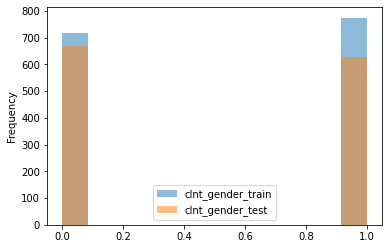

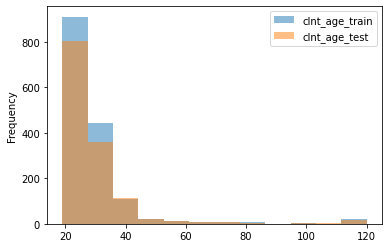

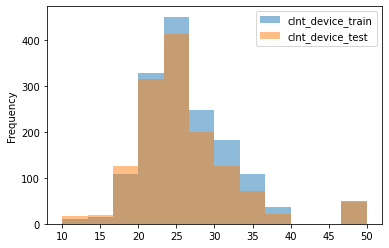

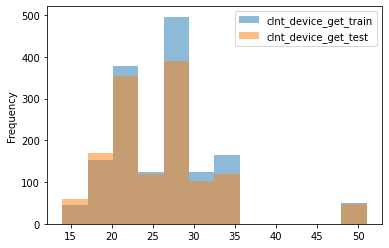

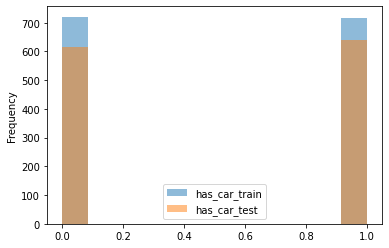

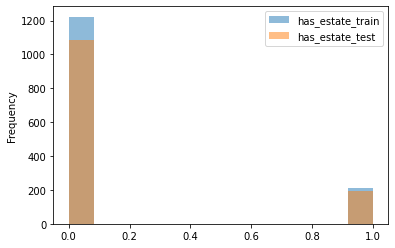

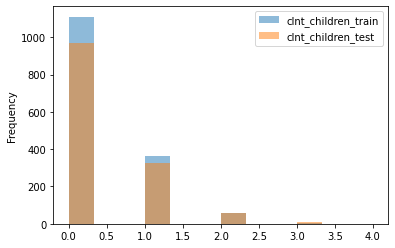

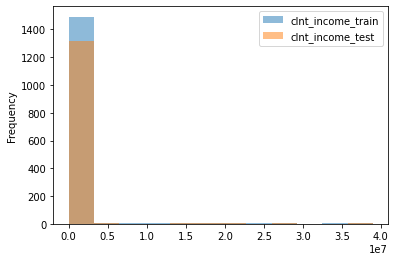

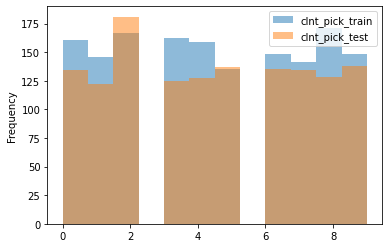

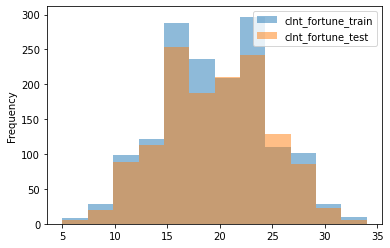

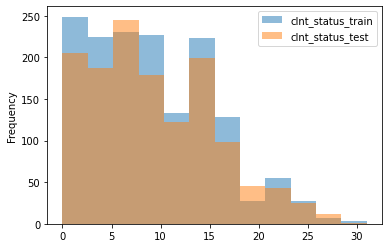

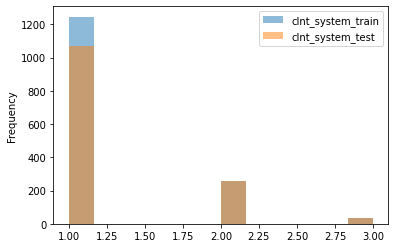

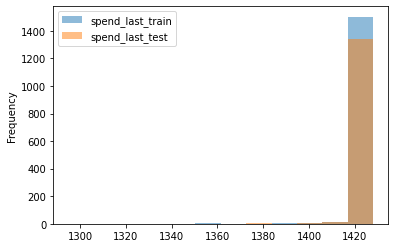

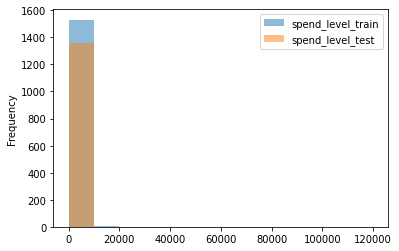

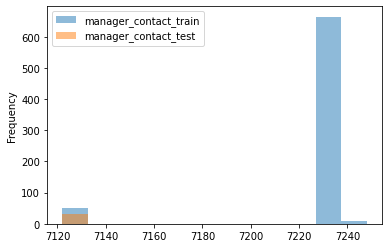

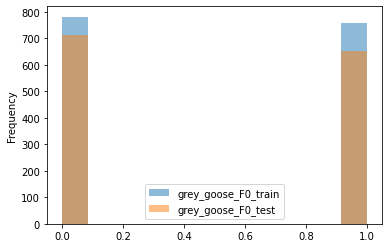

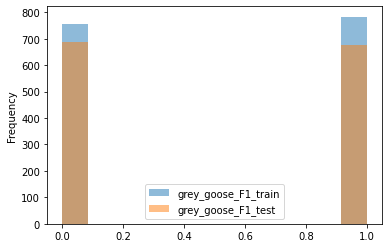

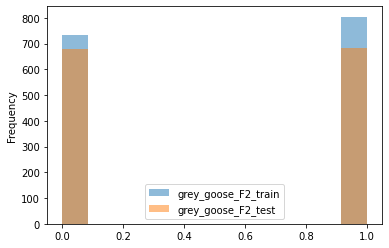

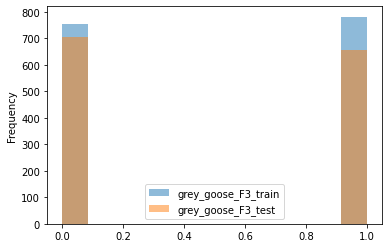

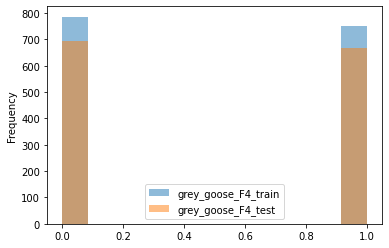

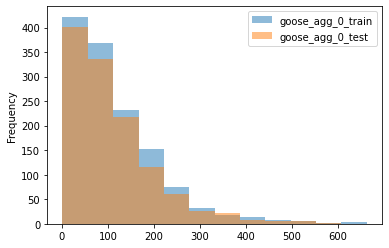

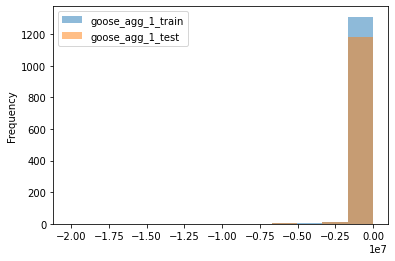

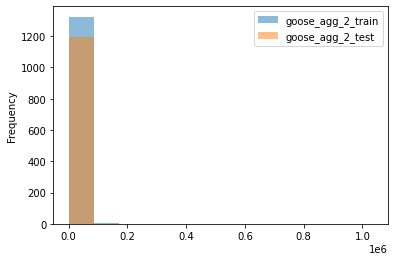

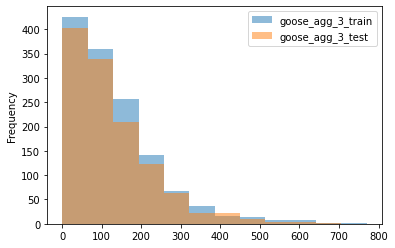

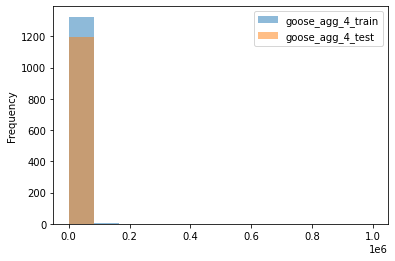

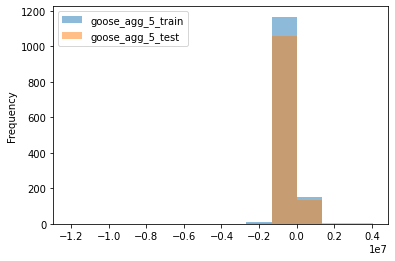

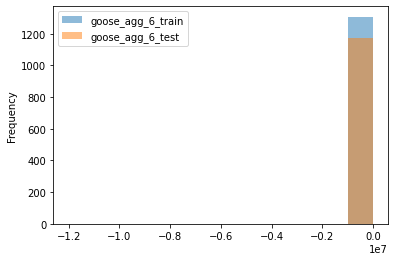

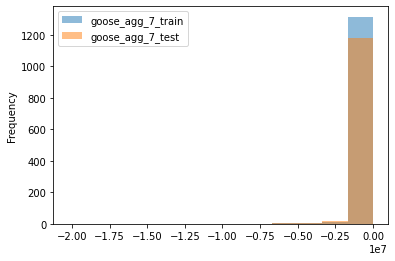

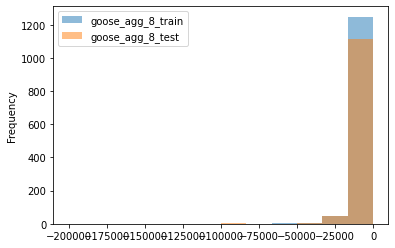

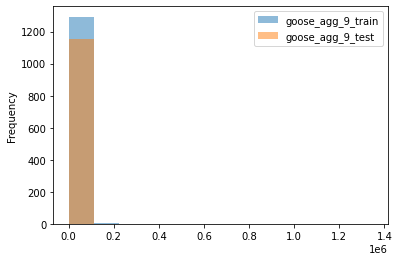

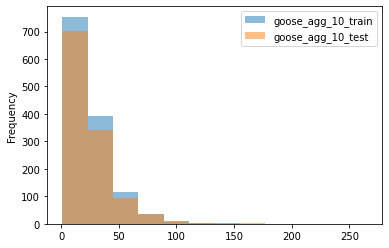

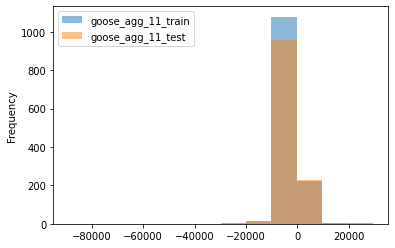

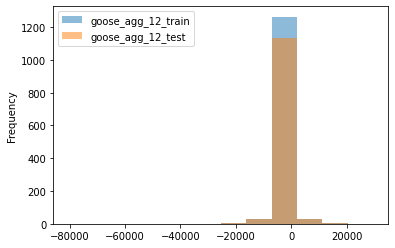

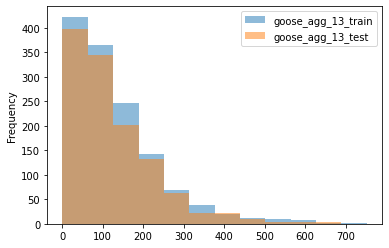

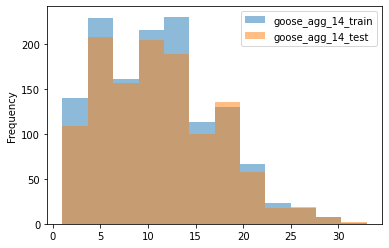

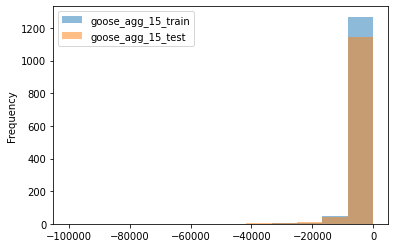

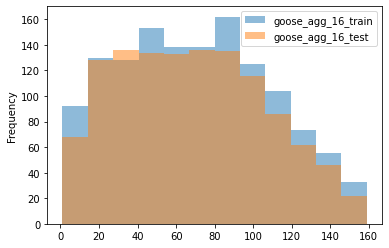

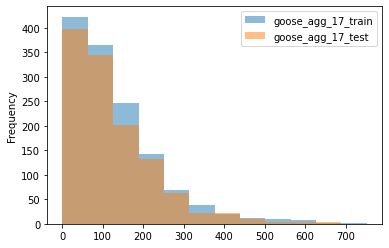

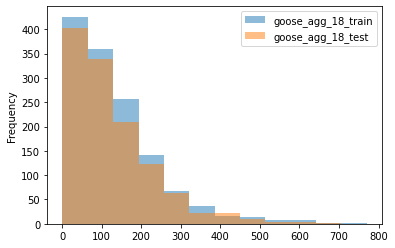

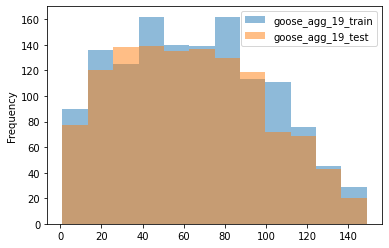

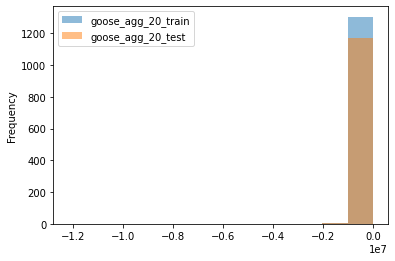

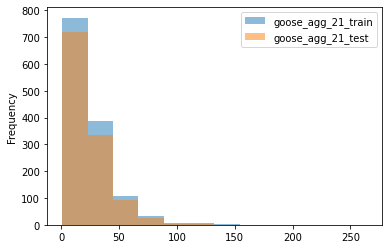

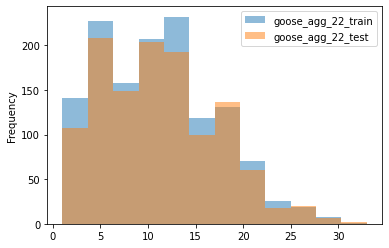

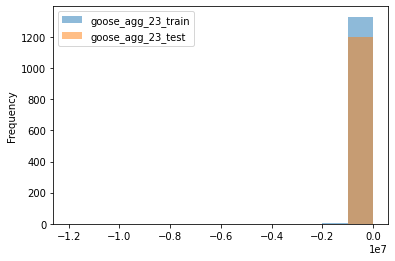

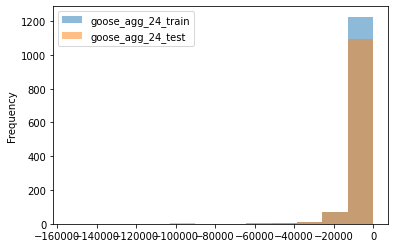

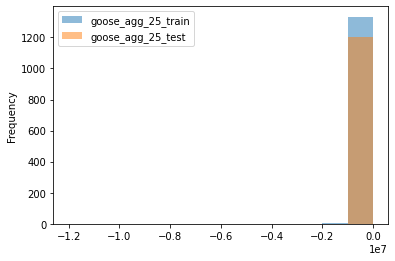

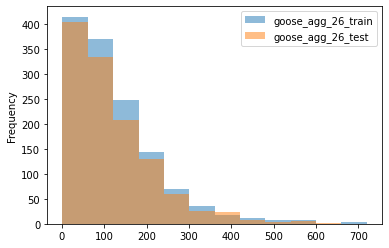

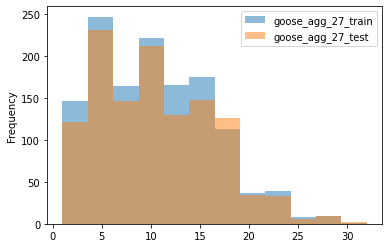

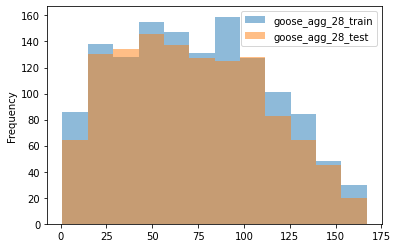

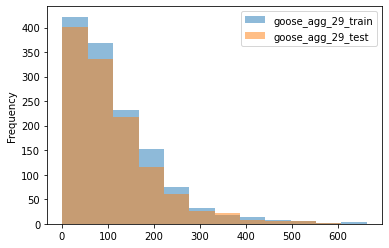

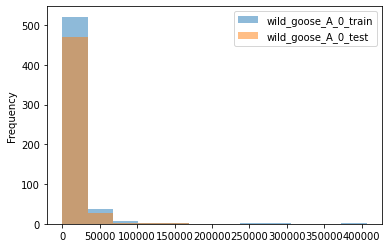

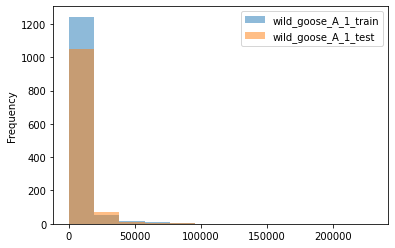

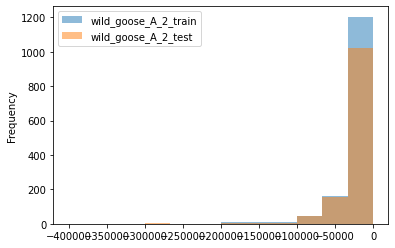

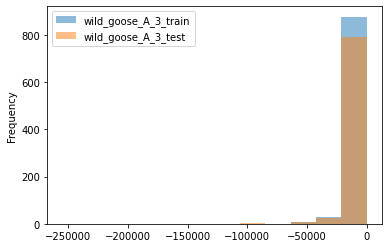

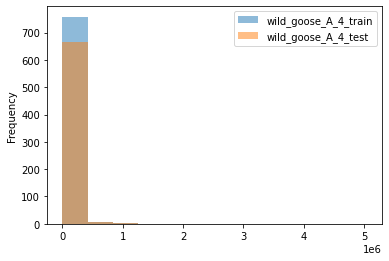

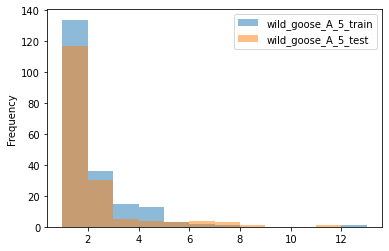

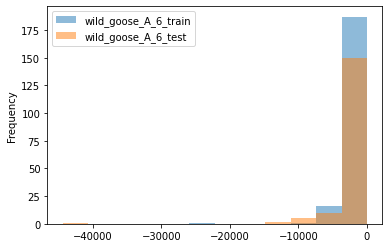

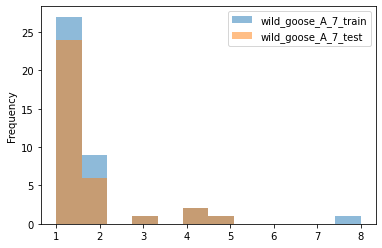

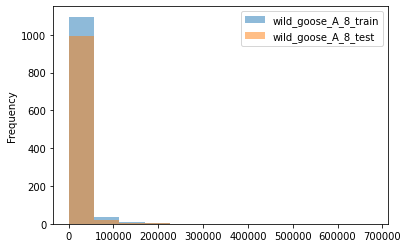

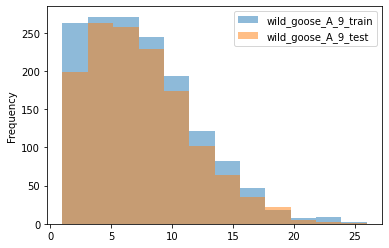

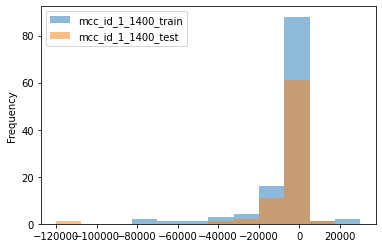

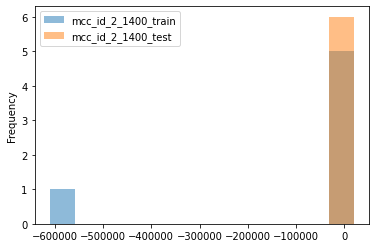

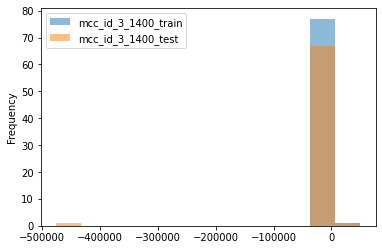

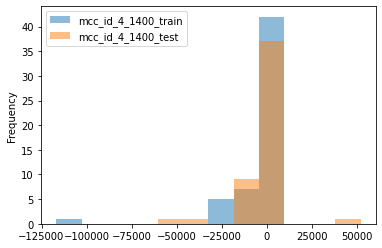

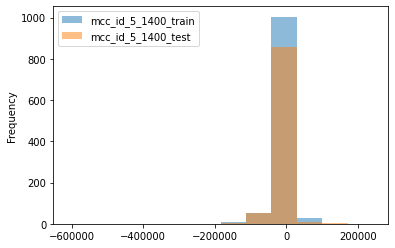

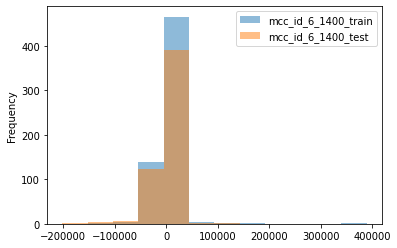

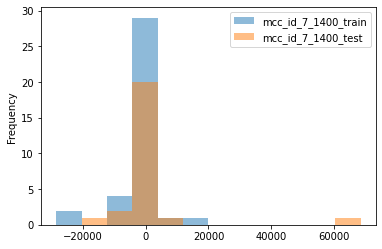

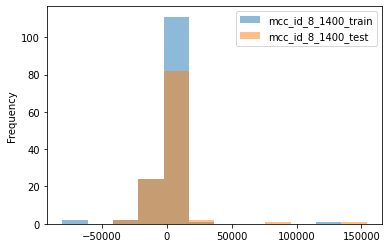

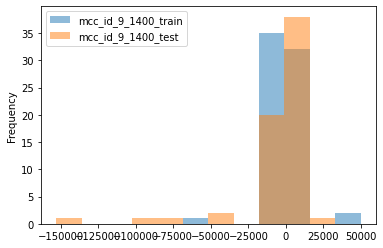

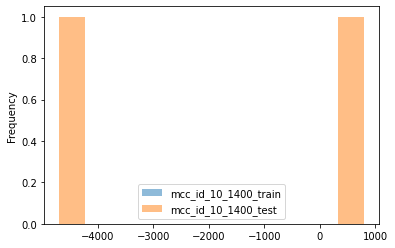

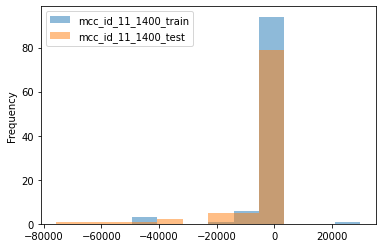

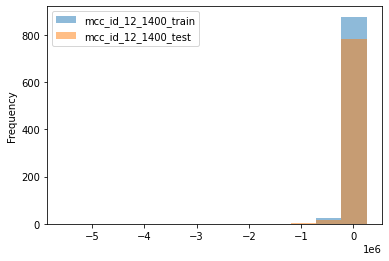

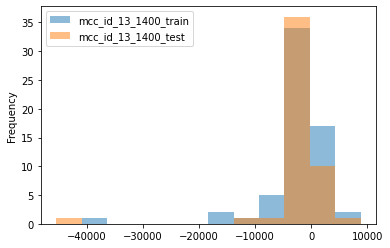

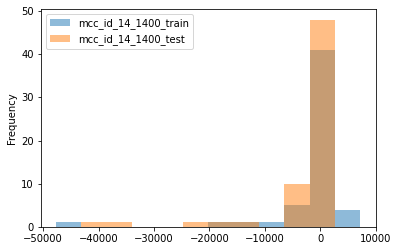

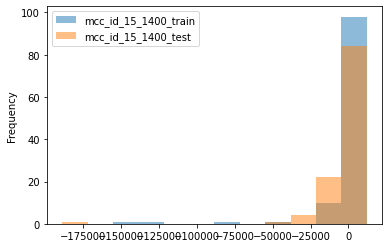

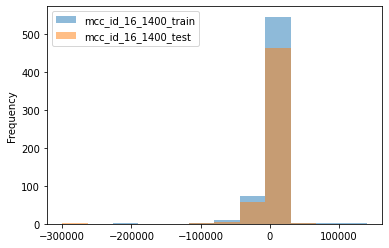

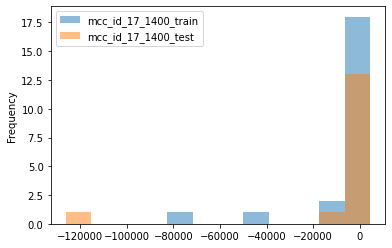

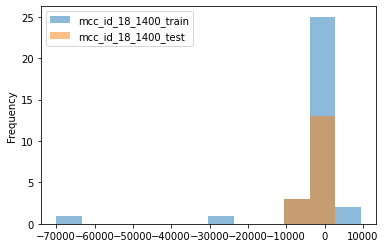

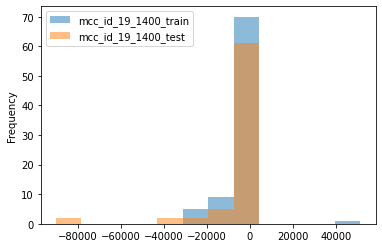

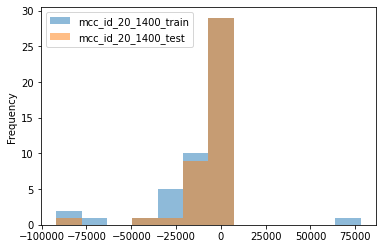

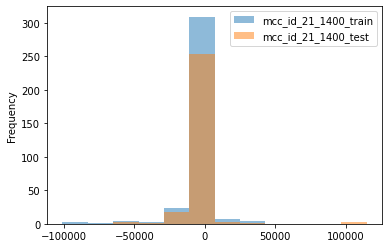

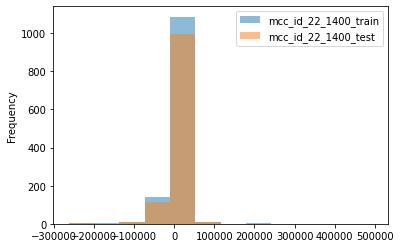

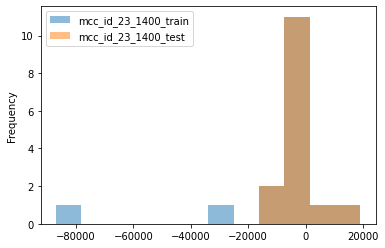

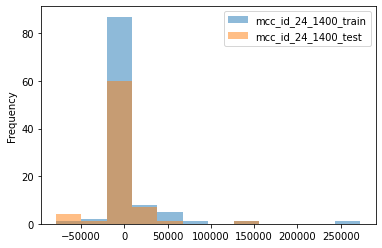

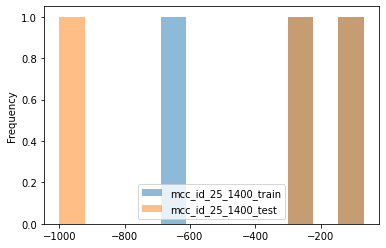

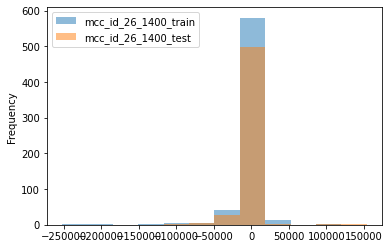

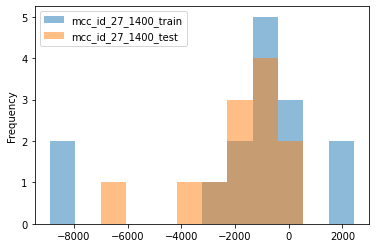

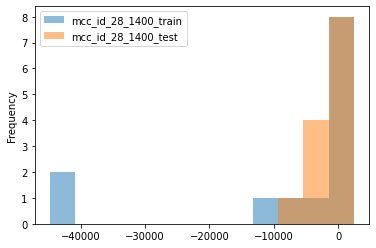

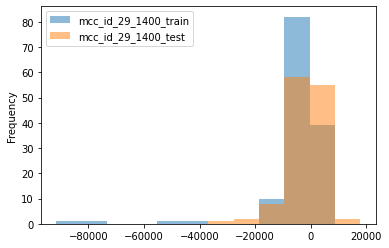

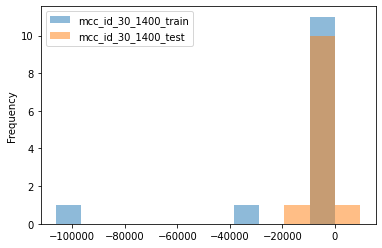

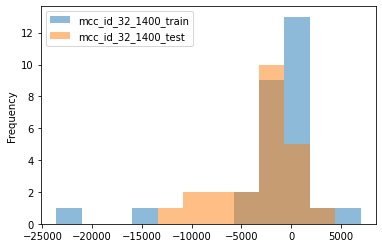

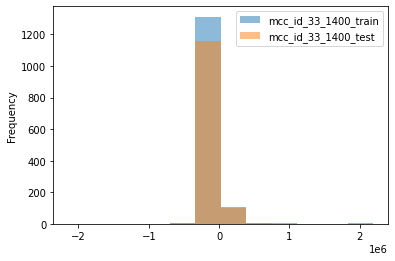

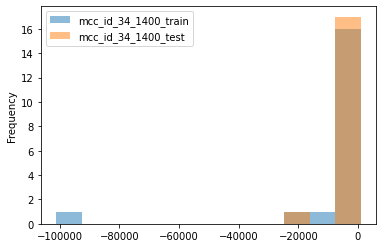

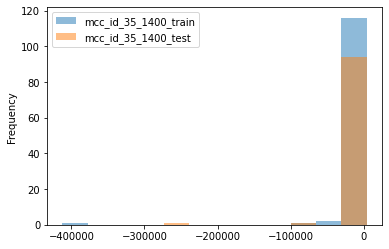

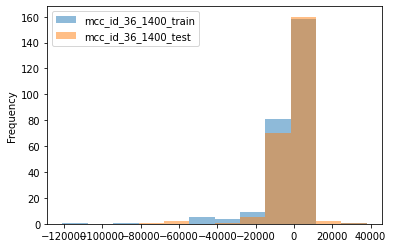

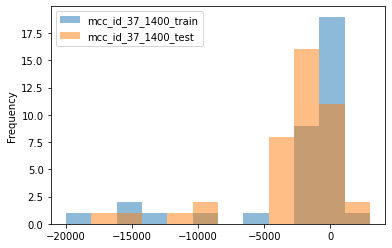

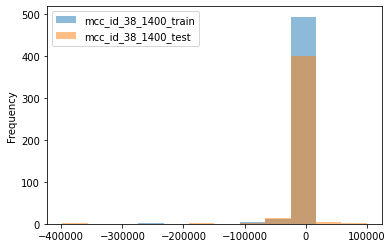

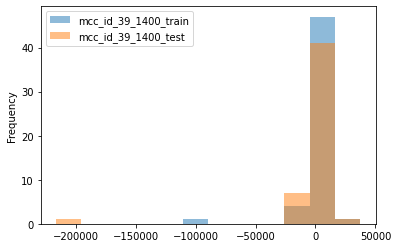

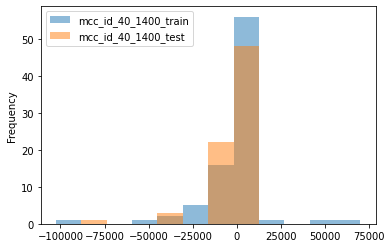

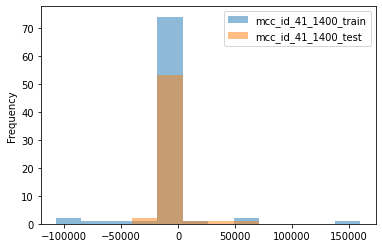

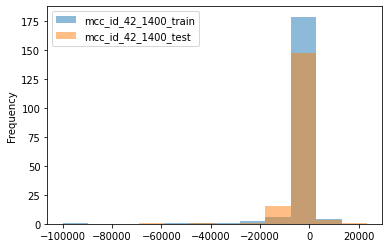

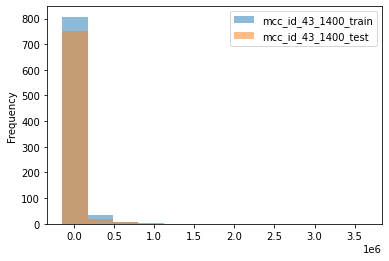

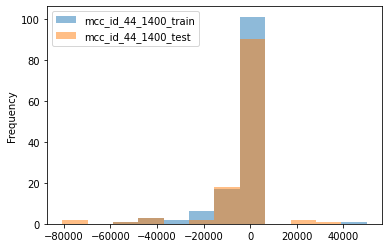

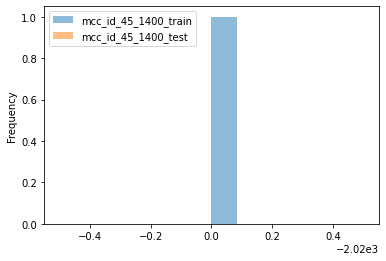

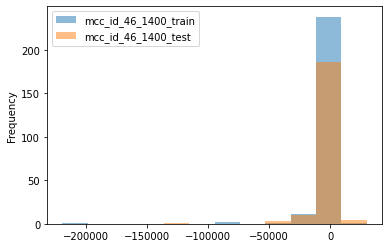

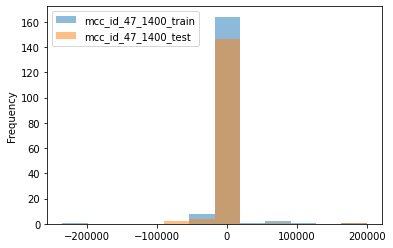

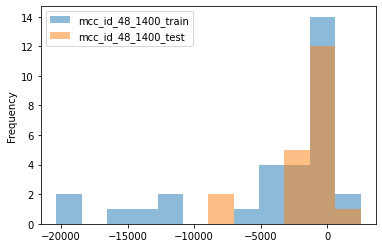

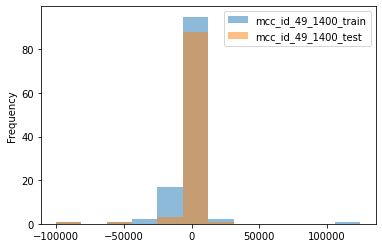

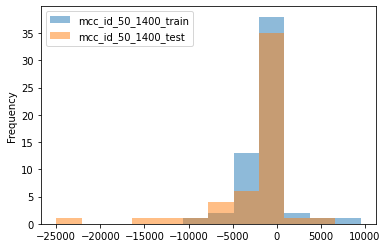

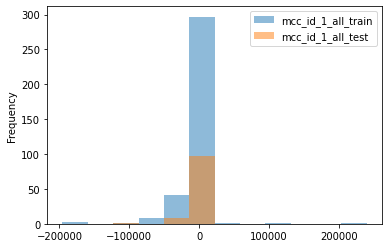

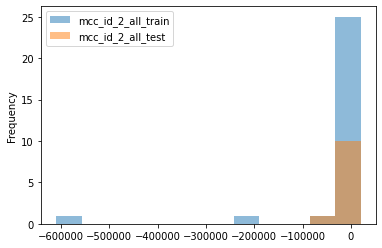

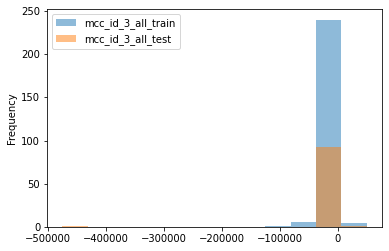

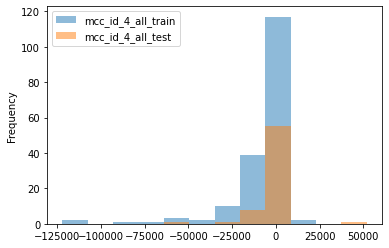

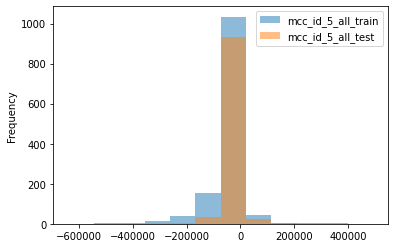

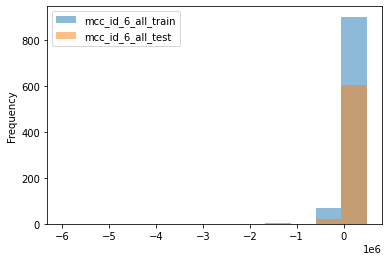

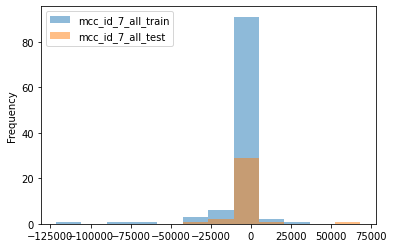

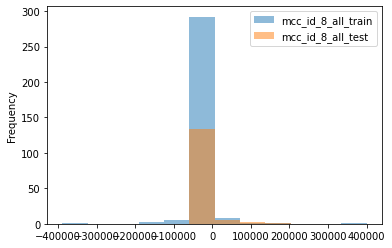

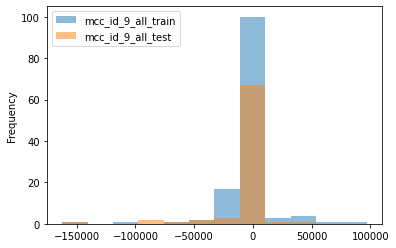

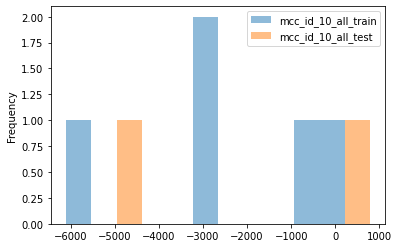

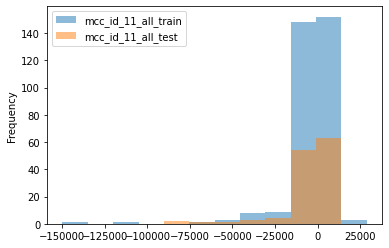

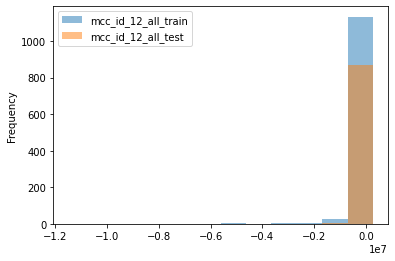

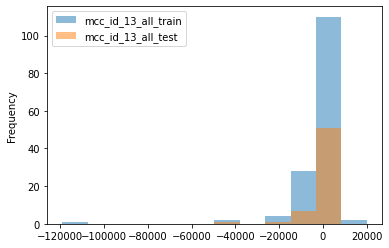

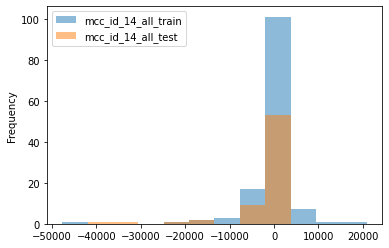

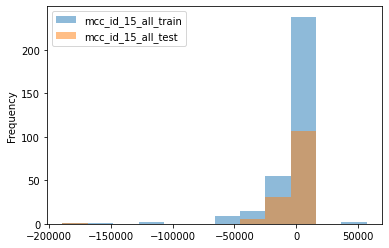

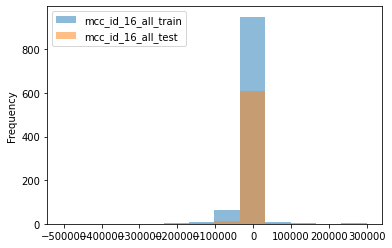

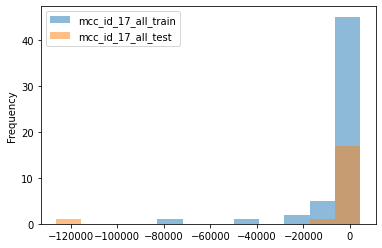

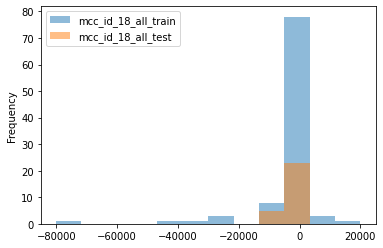

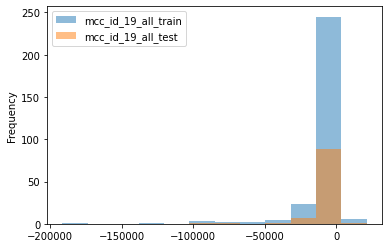

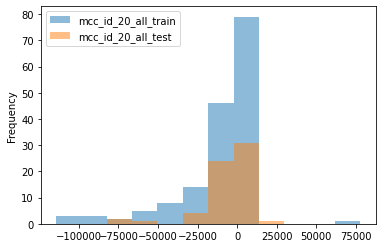

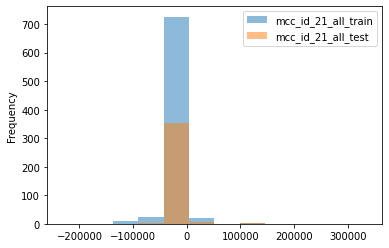

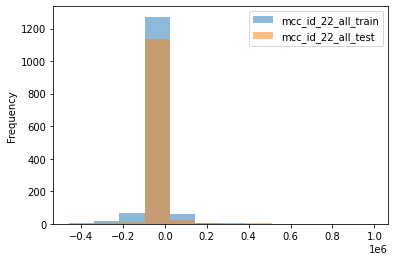

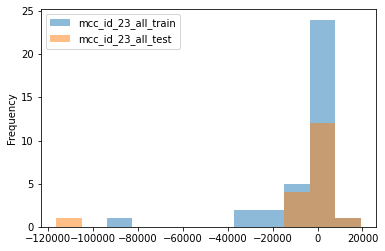

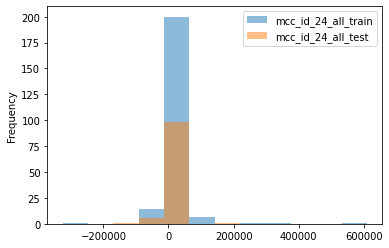

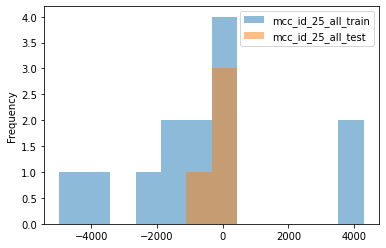

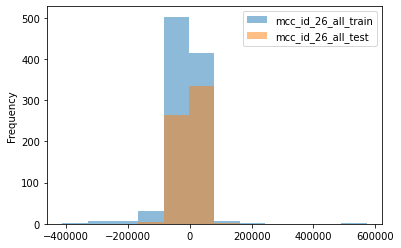

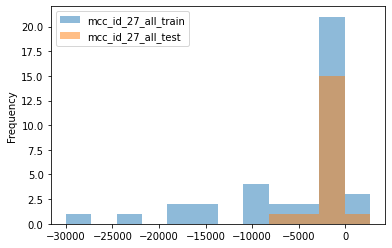

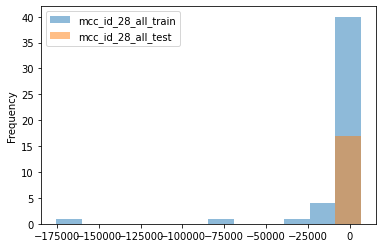

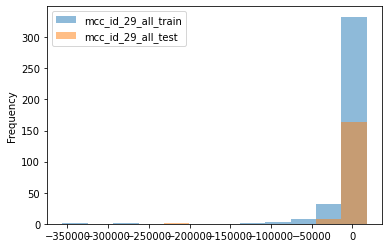

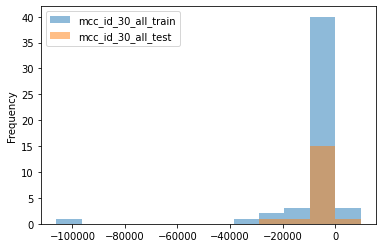

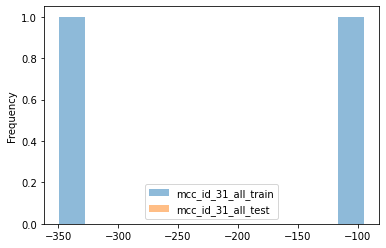

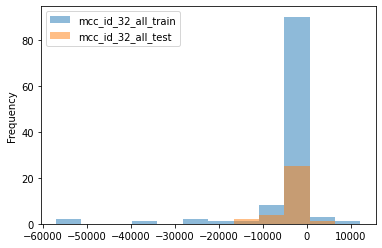

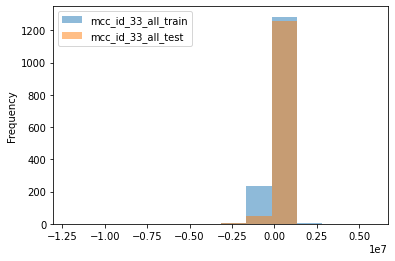

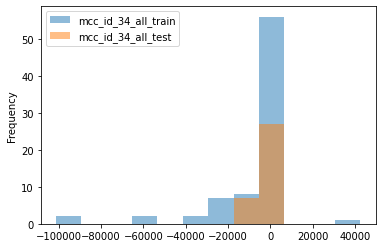

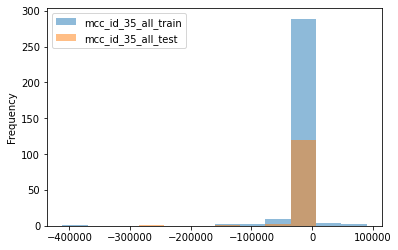

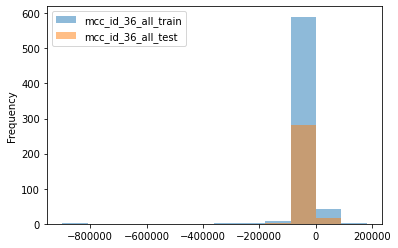

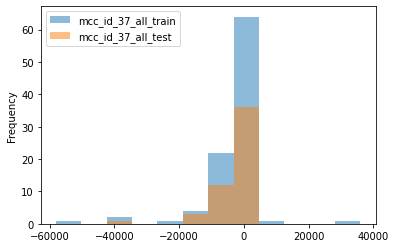

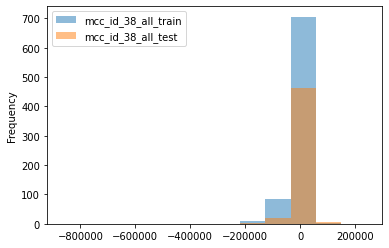

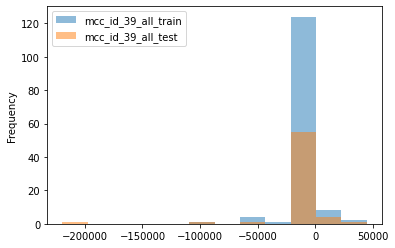

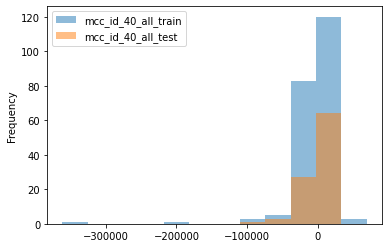

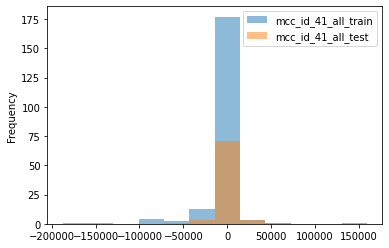

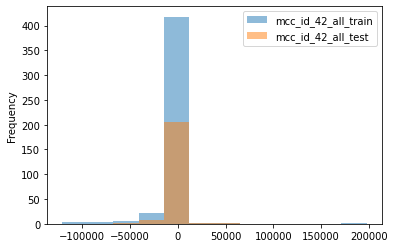

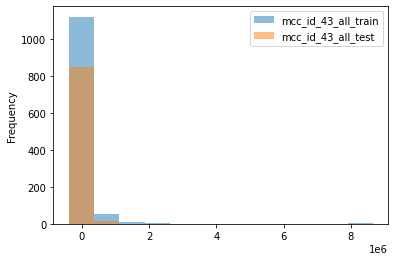

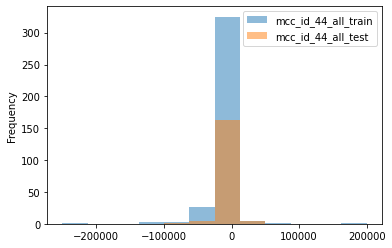

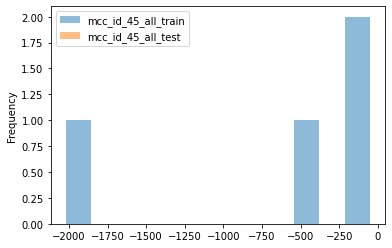

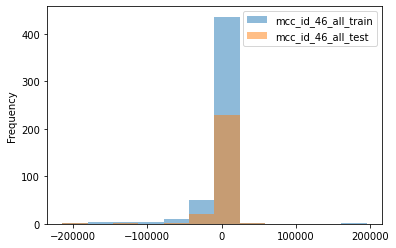

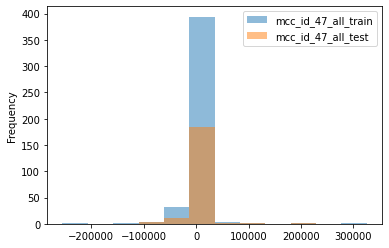

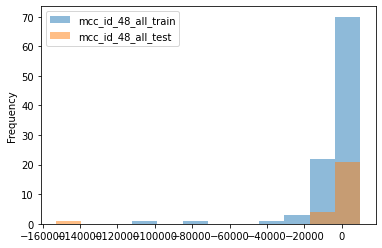

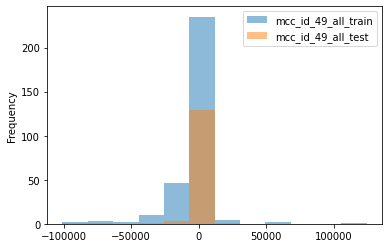

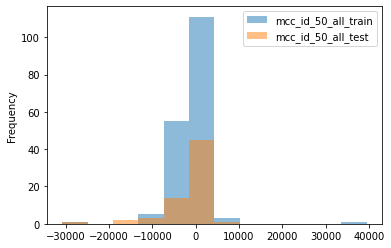

In [ ]:
for i in train_data.columns:
  df_f = pd.concat([train_data[i], test_data[i]], axis = 1)
  df_f.columns = [str(df_f.columns[0])+'_train', str(df_f.columns[1])+'_test']
  df_f.plot.hist(bins=12, alpha=0.5)

In [91]:
train_data['is_premium'] = train_y

На основе анализа часть фичей явно хочется ограничить, часть - отлогарифмировать до нормальности, а часть - инвертировать и отлогарифмировать. Сделаем это. 

**P.S. в некоторых кейсах были особенные значения, поэтому перебирал всё руками. Естественно это можно было автоматизировать, но уже очень хотелось спать)**

In [93]:
train_data = train_data[train_data['spend_level'] < 20000]

In [94]:
train_data['goose_agg_1'] = pd.Series(np.log(- train_data['goose_agg_1']))

In [95]:
test_data['goose_agg_1'] = pd.Series(np.log(- test_data['goose_agg_1']))

In [96]:
train_data['goose_agg_2'] = pd.Series(np.log(train_data['goose_agg_2']))
test_data['goose_agg_2'] = pd.Series(np.log(test_data['goose_agg_2']))


In [97]:
train_data['clnt_income'] = np.log(train_data['clnt_income'] + 1)
test_data['clnt_income'] = np.log(test_data['clnt_income'] + 1)

In [98]:
train_data['goose_agg_6'] = pd.Series(np.log(- train_data['goose_agg_6']))
test_data['goose_agg_6'] = pd.Series(np.log(- test_data['goose_agg_6']))

In [99]:
train_data['goose_agg_7'] = pd.Series(np.log(- train_data['goose_agg_7']))
test_data['goose_agg_7'] = pd.Series(np.log(- test_data['goose_agg_7']))

In [100]:
train_data['goose_agg_8'] = pd.Series(np.log(- train_data['goose_agg_8']))
test_data['goose_agg_8'] = pd.Series(np.log(- test_data['goose_agg_8']))

In [101]:
train_data['goose_agg_9'] = pd.Series(np.log(train_data['goose_agg_9']+1))
test_data['goose_agg_9'] = pd.Series(np.log(test_data['goose_agg_9']+1))


In [102]:
for i in ['goose_agg_10', 'wild_goose_A_0', 'wild_goose_A_1', 'wild_goose_A_4', 'wild_goose_A_5', 'wild_goose_A_8']:
  train_data[i] = pd.Series(np.log(train_data[i]+1))
  test_data[i] = pd.Series(np.log(test_data[i]+1))


In [103]:
test_data['wild_goose_A_6'].min(), test_data['wild_goose_A_6'].max()

(-44400.0, -1.0)

In [104]:
for i in ['goose_agg_15', 'goose_agg_20', 'goose_agg_23', 'goose_agg_24', 'goose_agg_25', 'wild_goose_A_2', 'wild_goose_A_3', 'wild_goose_A_6']:
  print(i)
  train_data[i] = pd.Series(np.log(- train_data[i]-2))
  test_data[i] = pd.Series(np.log(- test_data[i]-2))

goose_agg_15
goose_agg_20
goose_agg_23
goose_agg_24
goose_agg_25
wild_goose_A_2
wild_goose_A_3
wild_goose_A_6


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [105]:
mccs = []

for i in train_data.columns:
  if 'mcc' in i:
    mccs.append(i)

In [106]:
train_data[mccs]= train_data[mccs].fillna(0)

In [107]:
test_data[mccs]= test_data[mccs].fillna(0)

In [108]:
train_data.reset_index(inplace = True)
train_data.drop(columns = ['index'], inplace = True)

In [109]:
train_y = train_data['is_premium']
train_data.drop(columns = ['is_premium'], inplace=True)

In [ ]:
# С параметрами для модели я особо не парился, на ночь запустил перебор самых базовых параметров гридсерчем, сюда вынес уже итоги:
model_cb = CatBoostClassifier(learning_rate=0.01, n_estimators=493)

kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
scores_cb = []

data_res = []
models = []

for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data.loc[train_index], train_data.loc[test_index]
    y_train, y_test = train_y.loc[train_index], train_y.loc[test_index]

    manag_contact = X_test['manager_contact'].apply(lambda x: 1 if x >= 1 else 0).values

    X_train.drop(columns = ['manager_contact'], inplace = True)
    X_test.drop(columns = ['manager_contact'], inplace = True)
    
    model_cb.fit(X_train, y_train, verbose=False)

    print("Qual on train: ", sklearn.metrics.accuracy_score(y_train, \
                                                            pd.Series(model_cb.predict_proba(X_train)[:,1]).apply(lambda x: int(x > 0.85)).values))
    print("Qual on test: ", sklearn.metrics.accuracy_score(y_test, \
                                                           pd.Series(model_cb.predict_proba(X_test)[:,1]).apply(lambda x: int(x > 0.85)).values))
    
    print("Qual on train: ", sklearn.metrics.recall_score(y_train, \
                                                            pd.Series(model_cb.predict_proba(X_train)[:,1]).apply(lambda x: int(x > 0.85)).values))
    print("Qual on test: ", sklearn.metrics.recall_score(y_test, \
                                                           pd.Series(model_cb.predict_proba(X_test)[:,1]).apply(lambda x: int(x > 0.85)).values))
    

    #pred_cb = model_cb.predict(X_test)
    pred_cb = pd.Series(model_cb.predict_proba(X_test)[:,1]).apply(lambda x: int(x > 0.85)).values 
    pres_cb_new = pd.Series(pred_cb + manag_contact).apply(lambda x: 1 if x>= 1 else 0).values

    models.append(model_cb)
    scores_cb.append(sklearn.metrics.accuracy_score(y_test, pres_cb_new))
    
scores_cb = np.array(scores_cb)

data_res = [{'mean': scores_cb.mean(),  'std': scores_cb.std()}]

results_pd = pd.DataFrame(data = data_res, columns = ['mean','std'], index = ['Catboost'])

print(results_pd)

Qual on train:  0.6693811074918566
Qual on test:  0.5292207792207793
Qual on train:  0.2814159292035398
Qual on test:  0.08333333333333333
Qual on train:  0.6517493897477624
Qual on test:  0.5895765472312704
Qual on train:  0.2633390705679862
Qual on test:  0.12142857142857143
Qual on train:  0.6786004882017901
Qual on test:  0.5602605863192183
Qual on train:  0.3166089965397924
Qual on test:  0.1048951048951049
Qual on train:  0.6558177379983726
Qual on test:  0.5602605863192183
Qual on train:  0.2694300518134715
Qual on test:  0.06338028169014084
Qual on train:  0.6582587469487388
Qual on test:  0.5798045602605864
Qual on train:  0.27710843373493976
Qual on test:  0.10714285714285714
              mean       std
Catboost  0.988278  0.006045


In [ ]:
res_pred = np.zeros(len(test_data))

for model in models:
  y_pred = model.predict_proba(test_data)[:, 1]
  res_pred += y_pred

res_model = pd.Series(res_pred/5).apply(lambda x: 1 if x > 0.85 else 0)

res_df = pd.DataFrame(test_data['manager_contact'].apply(lambda x: 1 if x >= 1 else 0).values)
res_df.columns = ['managers_res']
res_df.shape

res_df['res_cb'] = res_model.values
res_df['big_res'] = (res_df['managers_res'] + res_df['res_cb']).apply(lambda x: 1 if x>= 1 else 0).values
res_df['score'] = pd.Series(res_pred/5)
res_df['clnt_id'] = test_data_buf['clnt_id'].values


res_df[(res_df['big_res'] == 1) & (res_df['managers_res'] == 0)].head(30)

,managers_res,res_cb,big_res,score,clnt_id
178,0,1,1,0.888005,2398
246,0,1,1,0.877172,2546
429,0,1,1,0.903233,2960
459,0,1,1,0.873393,3019
549,0,1,1,0.879704,3216
597,0,1,1,0.891648,3330
735,0,1,1,0.915637,3637
824,0,1,1,0.900301,3824
1198,0,1,1,0.896874,4643
1205,0,1,1,0.893424,4659


In [ ]:
s_subs = pd.read_csv("sample_submit.csv")
s_subs.head()

s_subs = s_subs.merge(res_df, on = 'clnt_id')
s_subs['is_premium'] = s_subs['big_res']
res_df['big_res'].value_counts()

0    1315
1      46
Name: big_res, dtype: int64

In [ ]:
s_subs[['clnt_id', 'is_premium']].to_csv('catboost_manag_thresh_v_last.csv', index = None)

In [ ]:
res_pred = np.zeros(len(test_data))

for model in models:
  y_pred = model.predict_proba(test_data)[:, 1]
  res_pred += y_pred

res_model = pd.Series(res_pred/5).apply(lambda x: 1 if x > 0.89 else 0)

res_df = pd.DataFrame(test_data['manager_contact'].apply(lambda x: 1 if x >= 1 else 0).values)
res_df.columns = ['managers_res']
res_df.shape

res_df['res_cb'] = res_model.values
res_df['big_res'] = (res_df['managers_res'] + res_df['res_cb']).apply(lambda x: 1 if x>= 1 else 0).values
res_df['score'] = pd.Series(res_pred/5)
res_df['clnt_id'] = test_data_buf['clnt_id'].values


s_subs = pd.read_csv("sample_submit.csv")
s_subs.head()

s_subs = s_subs.merge(res_df, on = 'clnt_id')
s_subs['is_premium'] = s_subs['big_res']
res_df['big_res'].value_counts()

0    1319
1      42
Name: big_res, dtype: int64

In [ ]:
s_subs[['clnt_id', 'is_premium']].to_csv('catboost_manag_thresh_v6.csv', index = None)